In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from tqdm.notebook import tqdm
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import glob
import os
import sys

from tqdm.notebook import tqdm
from datetime import datetime

import Cross_Eval
from Preprocessing_Methods import *
from stratgroupkfold import StratifiedGroupKFold

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.calibration import CalibratedClassifierCV

from sklearn.kernel_approximation import RBFSampler, Nystroem

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold, KFold, train_test_split

from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.utils import compute_class_weight, compute_sample_weight

from mlxtend.evaluate import scoring
from mlxtend.evaluate import BootstrapOutOfBag

In [3]:
# Preparing Metadata/Labels

In [4]:
all_files = pd.DataFrame(glob.glob("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])

try:all_files = pd.DataFrame(glob.glob("/mnt/d/Conor/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])
except:all_files = pd.DataFrame(glob.glob("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])

all_files = pd.DataFrame(glob.glob("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])

all_files["TMA"] = all_files.apply(lambda row: float(row["hdf_loc"].split("/")[-1][4:5]), axis = 1)
all_files["Core"] = all_files.apply(lambda row: row["hdf_loc"].split("/")[-1][8:-7], axis = 1)

In [5]:
try:metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx", sheet_name = "reformatted")
except:metadata = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx", sheet_name = "reformatted")

metadata = metadata.merge(all_files, left_on = ["TMA", "TMA site"], right_on = ["TMA", "Core"])
print(metadata.shape)

try:new_metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/new_metadata.xlsx")
except:new_metadata = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/new_metadata.xlsx")

(79, 18)


In [6]:
new_metadata["DODvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "DOD",
                             "alive": "Other",
                             "died other" : "Other",
                             "died" : "Other",
                             "Died" : "Other",
                             "Died other": "Other"})

new_metadata["DiedvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "Died",
                             "alive": "Alive",
                             "died other" : "Died",
                             "died" : "Died",
                             "Died" : "Died",
                             "Died other": "Died"})

new_metadata["ECS"] = new_metadata["ECS"].map(
                            {"y" : "Y",
                             "Y": "Y",
                             "N" : "N",
                             "n" : "N"})

In [7]:
new_metadata['lifespan'] = new_metadata['Date of death'] - new_metadata['date of diag']
new_metadata["Years"] = new_metadata['Date of death'].dt.year - new_metadata['date of diag'].dt.year

In [8]:
# Did the patient survive beyond n years?
for i in np.arange(0,5,1):
    
    s = (365*i)
    e = (365*(i+2))
    
    new_metadata[f"{i+1}year"] = new_metadata.apply(lambda row: True if s<(row['lifespan']).days<e and row.OUTCOME not in ['Alive',"alive"] else False, axis = 1)

In [9]:
new_metadata[f"1yeardeath"] = new_metadata.apply(lambda row: True if (row['lifespan']).days<365 and row.OUTCOME not in ['Alive',"alive"] else False, axis = 1)

bins = np.arange(0, new_metadata["Years"].max(),2)

new_metadata["2years"] = np.digitize(new_metadata["Years"], bins)

# Import ASMA data

In [10]:
try:asma = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")
except:asma = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")

new_metadata = new_metadata.merge(asma, left_on = "Patient_Number", right_on = "Case ID")

# Import data and preprocess

In [11]:
select = ['Tumour']

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).query(f"Tissue in {select}").sample(frac = 1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns
#total = total.merge(new_metadata, left_on = "Patient nu ", right_on = "Patient Number")
#total = total.drop(np.nan, level = "Overall Death ")

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).sample(frac = 0.1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns

In [12]:
total = total.reset_index().merge(new_metadata, left_on = "Patient nu ", right_on = "Patient_Number", how = 'inner')
total = total.set_index(list(total.columns.difference(wn_cols))).dropna(axis = 1)

In [13]:
total.to_hdf("./Tumour_df_raw.hdf5", key='Data')

Text(0, 0.5, 'Absorbance (a.u)')

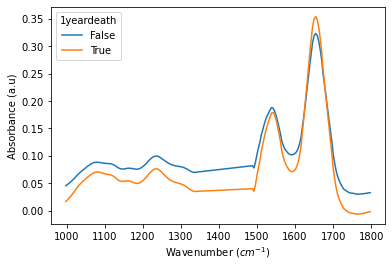

In [14]:
fig, axes = plt.subplots(nrows = 1, figsize = (6,4), sharex = True)

total.groupby("1yeardeath").mean().T.plot(ax = axes)
axes.set_xlabel("Wavenumber $(cm^{-1})$")
axes.set_ylabel("Absorbance (a.u)")
#fig.savefig(os.getcwd()+ "/Plots/Mean_ECS_Spectra.png", bbox_inches = 'tight')

# Kaplan Meier

In [15]:
from lifelines import KaplanMeierFitter

In [16]:
pats = total.groupby('Patient_Number').sample(1).reset_index().iloc[:,:-169]

In [17]:
duration  = pats['survival (months)']
death_obs = np.array([1 if i!='Died' else 0 for i in pats['DiedvsAlive']])

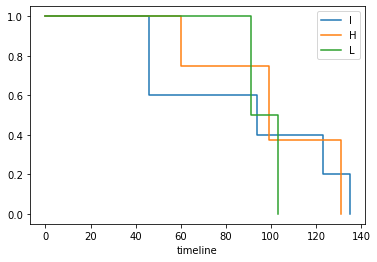

In [18]:
kmf = KaplanMeierFitter()

fig, ax = plt.subplots()

group = 'ASMA'

for g in pats[group].dropna().unique():

    kmf.fit(duration[(pats[group]==g)], death_obs[(pats[group]==g)], label=g)
    kmf.plot(ax=ax, ci_show=False)

In [19]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.cross_decomposition import PLSRegression

class PLSRegressionWrapper(PLSRegression):

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)

In [36]:
numeric_pipe = Pipeline([
("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
#("Normalise spectra", FunctionTransformer(normalize, kw_args = {"axis": 1})),
#("Normalise spectra", FunctionTransformer(minmax_scale, kw_args = {"axis": 1})),
("Scaler", MinMaxScaler()),
#("Scaler", StandardScaler()),
("PCA", PCA(0.99)),
#('PLS', PLSRegressionWrapper(n_components=10))
])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

in_df = total.reset_index(['ASMA']).dropna().sample(1000)
#in_df = total.sample(10000)

in_df.columns = [str(col) for col in in_df.columns]

ct = make_column_transformer(
    (numeric_pipe,     make_column_selector(dtype_include=np.number)),
    (categorical_pipe, make_column_selector(dtype_include=object))
)

In [37]:
preproc = pd.DataFrame(ct.fit_transform(in_df, in_df.reset_index()['1yeardeath']), index = in_df.index)

# Bayesian Logistic Regression

In [58]:
import pymc3 as pm
import theano as th

y = "1yeardeath"

train_pat, test_pat = train_test_split(pats.reset_index()['Patient_Number'], test_size=0.33, random_state=np.random.randint(0,100))


train_data = preproc.query(f"Patient_Number in {list(train_pat)}")
test_data = preproc.query(f"Patient_Number in {list(test_pat)}")

X_train = train_data
X_test = test_data

y_train, y_test = train_data.reset_index()[f"{y}"], test_data.reset_index()[f"{y}"]

print(train_data.reset_index()[y].value_counts())
print(test_data.reset_index()[y].value_counts())

False    516
True     194
Name: 1yeardeath, dtype: int64
False    217
True      73
Name: 1yeardeath, dtype: int64


ax=sns.pairplot(preproc.reset_index(['1yeardeath']).sample(100), hue='1yeardeath')

In [59]:
ncon = 13
ncat = 3

with pm.Model() as logistic_model:

    data_ = pm.Data('Pred', X_train.T)

    ɛ = pm.HalfNormal('ɛ', sd=1, shape = (ncat+ncon+1,1))
 
    # Continuous variables for each PC
    β1 = pm.Normal("β1", mu=0, sigma=1, shape = (ncon+1,1))

    # Categorical variables 
    β2 = pm.Categorical("β2", [1/ncat for _ in range(1, ncat+1)], shape=(ncat,1))

    # β.T + ɛ
    z = pm.math.dot(pm.math.concatenate([(β1[1:]+ɛ[1:-ncat]), (β2 + ɛ[-ncat:])]).T, data_)

    # Probability of parameter P given the data
    p = pm.Deterministic('P', pm.math.sigmoid(z + (β1[0] + ɛ[0])))

In [60]:
with logistic_model:

    obs = np.array([1.0 if el else 0.0 for el in y_train])

    observed = pm.Bernoulli("p", p, observed=obs.T)
    start=pm.find_MAP()

    #trace = pm.sample(10000, tune=100, start=start, step=step)
    trace = pm.sample(1000, tune=3000, start=start, init="adapt_diag", cores=1)

logp = -157.21, ||grad|| = 0.10497: 100%|██████████| 320/320 [00:00<00:00, 1389.10it/s] 
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [β1, ɛ]
>CategoricalGibbsMetropolis: [β2]
Sampling chain 1, 21 divergences: 100%|██████████| 4000/4000 [00:41<00:00, 95.47it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.695466125006526, but should be close to 0.8. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6292035686872081, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


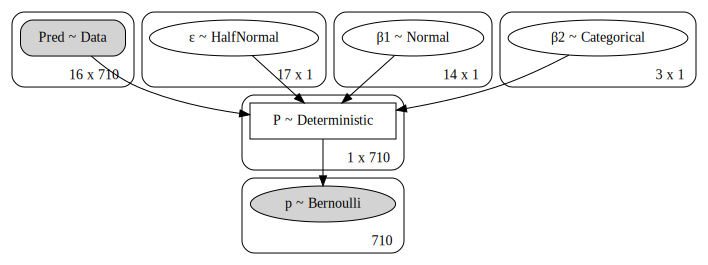

In [61]:
pm.model_graph.model_to_graphviz(logistic_model)

In [62]:
def exp_mean(array):

    hist, edges = np.histogram(array)
    hist = hist/np.sum(hist)

    centres = (edges[:-1] + edges[1:])/2

    return np.sum(hist*centres)

In [ ]:
trace["P"]

Text(0, 0.5, 'Likelihood')

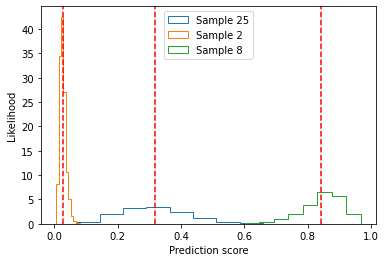

In [130]:
for i in [25,2,8]:
    
    plt.hist(trace["P"].squeeze()[:,i], histtype='step', density=True, label=f'Sample {i}')
    plt.axvline(trace["P"].squeeze()[:,i].mean(), ls='--', c='r')

plt.legend()
plt.xlabel('Prediction score')
plt.ylabel('Likelihood')

Text(0, 0.5, 'Likelihood')

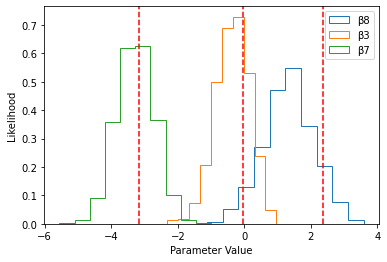

In [137]:
for i in [9,4,8]:
    
    plt.hist(trace["β1"].squeeze()[:,i], histtype='step', density=True, label=f'β{i-1}')
    #plt.axvline(trace["β1"].squeeze()[:,i].mean(), ls='--', c='r')
    plt.axvline(lr.coef_[:,i-1], ls='--', c='r')


plt.legend()
plt.xlabel('Parameter Value')
plt.ylabel('Likelihood')

In [63]:
p_df = pd.DataFrame(trace['P'].squeeze())

In [64]:
y_score_U = np.mean(trace['P'], axis=0).flatten()

In [65]:
y_score_w = p_df.apply(exp_mean, axis=0)

In [66]:
obs.shape

(710,)

No handles with labels found to put in legend.
Weighted: 0.9833672980100696
Unweighted: 0.9833672980100696


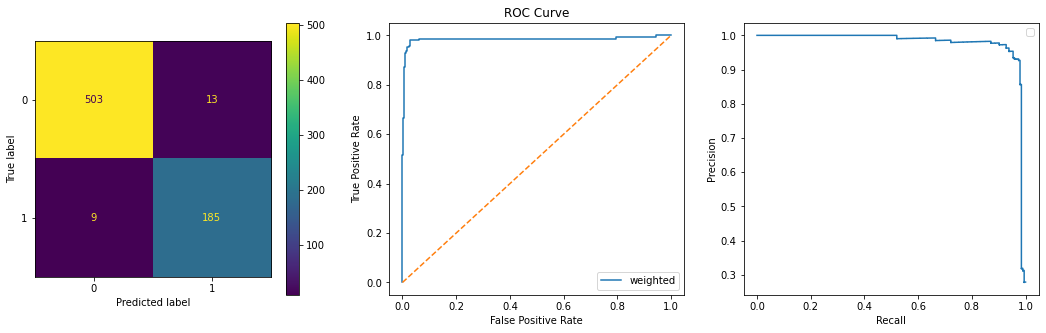

In [67]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (18,5))

preds = [1 if el > 0.5 else 0 for el in y_score_U]

cm = confusion_matrix(obs, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)

fpr_w, tpr_w, thresh_w = roc_curve(obs, y_score_w);

print("Weighted: {}".format(roc_auc_score(obs, y_score_U)))
print("Unweighted: {}".format(roc_auc_score(obs, y_score_U.flatten())))

RocCurveDisplay(fpr=fpr_w, tpr=tpr_w).plot(label='weighted', ax=ax2)
#ax2.plot(fpr_u, tpr_u, label='unweighted')
ax2.legend();
ax2.set_title("ROC Curve")
ax2.plot([0,1],[0,1], ls='--')

prec, recall, _ = precision_recall_curve(obs, y_score_U)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
ax3.legend()

In [68]:
with logistic_model:
    # update values of predictors:
    pm.set_data({"Pred": X_test.T})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["P"])

    model_preds = posterior_predictive["P"]

t_df = pd.DataFrame(model_preds.squeeze())

100%|██████████| 2000/2000 [00:01<00:00, 1720.84it/s]


array([[ 0.57201321,  0.55914735, -1.04363878, -0.03669664, -2.02821682,
         0.84389452, -0.60544186, -3.15320586,  2.37259618,  5.42421219,
        -0.31371897,  0.76557552,  0.3638937 ,  3.05996146, -0.34107265,
        -2.71960914]])

No handles with labels found to put in legend.
AUC: 0.73
Specificity: 0.72
Sensitivity: 0.93


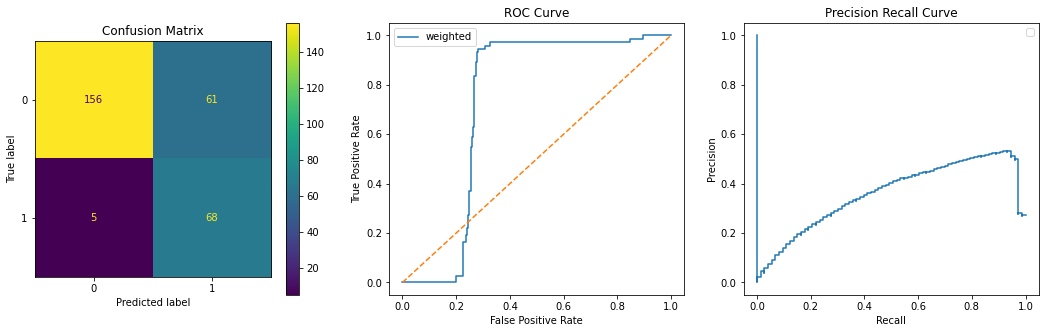

In [69]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

y_preds = lr.predict_proba(X_test)[:,1]

all = []    

thresholds = np.linspace(0,1,20)

for thresh in thresholds:

    preds = [1 if el > thresh else 0 for el in y_preds]

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.flatten()

    sens, spec = tp/(tp+fn), tn/(tn+fp)

    #print(f"Specificity: {spec}")
    #print(f"Sensitivity: {sens}")

    all.append(sens+spec)

op = thresholds[np.argmax(all)]



fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (18,5))

#y_preds = t_df.mean(axis=0)

preds = [1 if el > op else 0 for el in y_preds]

cm = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title("Confusion Matrix")
fpr_w, tpr_w, thresh_w = roc_curve(y_test, y_preds);

print("AUC: {:.2f}".format(roc_auc_score(y_test, y_preds)))
#print("Unweighted: {}".format(roc_auc_score(y_test, y_preds.flatten())))

RocCurveDisplay(fpr=fpr_w, tpr=tpr_w).plot(label='weighted', ax=ax2)
#ax2.plot(fpr_u, tpr_u, label='unweighted')
ax2.legend();
ax2.set_title("ROC Curve")
ax2.plot([0,1],[0,1], ls='--')

prec, recall, _ = precision_recall_curve(y_test, y_preds)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
ax3.legend()
ax3.set_title("Precision Recall Curve")

tn, fp, fn, tp = cm.flatten()

print(f"Specificity: {tn/(tn+fp):.2f}")
print(f"Sensitivity: {tp/(tp+fn):.2f}")


In [70]:
all = []    

thresholds = np.linspace(0,1,20)

for thresh in thresholds:

    preds = [1 if el > thresh else 0 for el in y_preds]

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.flatten()

    sens, spec = tp/(tp+fn), tn/(tn+fp)

    #print(f"Specificity: {spec}")
    #print(f"Sensitivity: {sens}")

    all.append(sens+spec)

op = thresholds[np.argmax(all)]

In [71]:
def row_max(row):

    hist, edges = np.histogram(row, bins=np.linspace(0,1,100))

    centres = (edges[:-1] + edges[1:])/2

    return centres[np.argmax(hist)]

In [72]:
def row_sum(row):

    hist, edges = np.histogram(row, density=True, bins=np.linspace(0,1,100))

    centres = (edges[:-1] + edges[1:])/2

    return np.where(centres<0.5, hist, 0)

No handles with labels found to put in legend.
AUC: 0.72
Specificity: 0.69
Sensitivity: 0.95


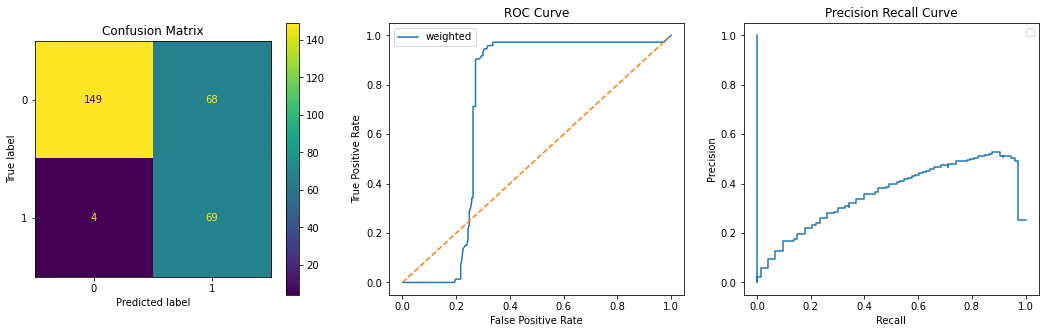

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (18,5))

y_preds = t_df.apply(row_max, axis=0)
#y_preds = t_df.mean(axis=0)


all = []    

thresholds = np.linspace(0,1,20)

for thresh in thresholds:

    preds = [1 if el > thresh else 0 for el in y_preds]

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.flatten()

    sens, spec = tp/(tp+fn), tn/(tn+fp)

    #print(f"Specificity: {spec}")
    #print(f"Sensitivity: {sens}")

    all.append(sens+spec)

op = thresholds[np.argmax(all)]


preds = [1 if el > op else 0 for el in y_preds]

cm = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title("Confusion Matrix")
fpr_w, tpr_w, thresh_w = roc_curve(y_test, y_preds);

print("AUC: {:.2f}".format(roc_auc_score(y_test, y_preds)))
#print("Unweighted: {}".format(roc_auc_score(y_test, y_preds.flatten())))

RocCurveDisplay(fpr=fpr_w, tpr=tpr_w).plot(label='weighted', ax=ax2)
#ax2.plot(fpr_u, tpr_u, label='unweighted')
ax2.legend();
ax2.set_title("ROC Curve")
ax2.plot([0,1],[0,1], ls='--')

prec, recall, _ = precision_recall_curve(y_test, y_preds)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
ax3.legend()
ax3.set_title("Precision Recall Curve")

tn, fp, fn, tp = cm.flatten()

print(f"Specificity: {tn/(tn+fp):.2f}")
print(f"Sensitivity: {tp/(tp+fn):.2f}")

In [74]:
import arviz as az

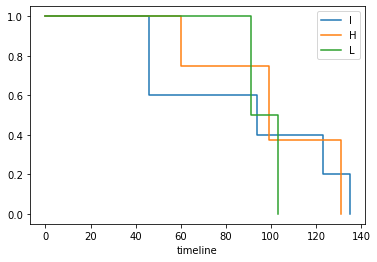

In [75]:
kmf = KaplanMeierFitter()

pats = total.groupby('Patient_Number').sample(1).reset_index().iloc[:,:-169]

duration  = pats['survival (months)']
death_obs = np.array([1 if i!='Died' else 0 for i in pats['DiedvsAlive']])

fig, ax = plt.subplots()

group = 'ASMA'

for g in pats[group].dropna().unique():

    kmf.fit(duration[(pats[group]==g)], death_obs[(pats[group]==g)], label=g)
    kmf.plot(ax=ax, ci_show=False)